In [1]:
%matplotlib inline

import os
import re
import numpy as np
import pandas as pd
import gensim
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder

# modeling imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# store models
import pickle

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
sns.set()

# database imports
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

[nltk_data] Downloading package punkt to /home/clutch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))


### Locate PostgreSQL Key and Connect to DB

In [2]:
# # using function from "Keeping API Keys Secret.ipynb"
# # by https://github.com/dylburger
# def get_file_contents(filename):
#     """ 
#     Given a filename,
#     return the contents of that file
#     """
#     try:
#         with open(filename, 'r') as f:
#             # assumed file is a single line with key
#             return f.read().strip()
#     except FileNotFoundError:
#         print("'%s' file not found" % filename)

In [3]:
# # define a database name (we're using a dataset on births, so we'll call it birth_db)
# # Set your postgres username
# dbname = 'insight_db'
# username = 'postgres' # change this to your username
# password = get_file_contents('../keys/psql_key')

In [4]:
# # 'engine' is a connection to a database
# engine = create_engine('postgres://%s:%s@localhost/%s'%(username,password,dbname))
# # load sql_magic so we can write SQL in Jupyter Notebooks
# %load_ext sql_magic

# # setup SQL connection to the postgreSQL engine we created
# %config SQL.conn_name = 'engine'
# print(engine.url)

In [5]:
# # connect to make queries using psycopg2
# con = psycopg2.connect(database = dbname, host = 'localhost', user = username, password = password)
# con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

In [6]:
# # load data from videos table into dataframe
# data_df = pd.read_sql('SELECT * from videos', con=con)
# data_df.drop(columns=['id', 'upload_date', 'duration', 
#                       'view_count', 'likes', 'dislikes', 
#                       'video', 'thumbnail'], inplace=True)
# #data_df.groupby('primary_category').video_id.count()

In [7]:
from_csv_filename = 'data/csv_files/summarized_data.csv'

In [8]:
data_df = pd.read_csv(from_csv_filename, sep=',')

In [9]:
data_df.head()

,video_id,title,subtitles,primary_category,text,txt_len,summary
0,09Q4JQ3p8yg,How to remove popcorn stipple ceiling,hi Shannon here from health improvements and t...,drywall_repair,"asmr **, I love you, Im here from Instagram lm...",90480,"Ines rivera meeeeeee, me, 🙋‍♀️guilty, me, ines..."
1,0Aip_xxpia4,How to install carpet tiles,were going to replace this tired old wall-to-w...,carpet_flooring,Interface do a product called tactiles which a...,2183,"If you're able to :), use a mover disc for fuc..."
2,0COOF3BwgKI,Fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools..."
3,0J8q_Lsh4fU,Hog wire deck rail installation,hi im paul from Elkins diy.com today Im going ...,build_deck,"Thanks Naegling, off topic but where are u get...",8102,"Silicone in the crevices is a great idea, 사랑합니..."
4,0RuwaSU71rY,Replacing a section of drywall after a pipe leak,hi Im Mike Thompson last night was a bit of an...,drywall_repair,"Great Job , Mike Thompson, good instructional ...",4012,"Great job , mike thompson, good instructional ..."


In [12]:
data_df.video_id.count()

1037

### Split Data into Training Set and Test Set

#### Training Data Selection

In [13]:
# remove underscores from title and create new feature
# with title and description combined
# data_df['title'] = data_df['title'].str.replace('_',' ')
#data_df['title_and_descr'] = data_df.title + '. ' + data_df.description

In [14]:
# randomly select subset of 70% rows for each class to train models
random_state = 42
deck_df = data_df[data_df['primary_category']=='build_deck'].sample(n=144, random_state=random_state)
carpet_df = data_df[data_df['primary_category']=='carpet_flooring'].sample(n=100, random_state=random_state)
drywall_df = data_df[data_df['primary_category']=='drywall_repair'].sample(n=203, random_state=random_state)
laminate_df = data_df[data_df['primary_category']=='laminate_flooring'].sample(n=116, random_state=random_state)
fence_df = data_df[data_df['primary_category']=='repair_wood_fence'].sample(n=138, random_state=random_state)

In [15]:
# concatenate the different training dataframes
training_df = pd.concat([deck_df, carpet_df, drywall_df, laminate_df, fence_df])

#### Testing Data Selection

In [16]:
# select remaining data as testing set
common_df = training_df.merge(data_df,on=['video_id'])
testing_df = data_df[(~data_df.video_id.isin(common_df.video_id))]

In [17]:
training_df.video_id.count()

701

In [18]:
print(training_df[training_df['primary_category']=='build_deck'].video_id.count())
print(training_df[training_df['primary_category']=='carpet_flooring'].video_id.count())
print(training_df[training_df['primary_category']=='drywall_repair'].video_id.count())
print(training_df[training_df['primary_category']=='laminate_flooring'].video_id.count())
print(training_df[training_df['primary_category']=='repair_wood_fence'].video_id.count())

144
100
203
116
138


In [19]:
testing_df.video_id.count()

308

In [20]:
print(testing_df[testing_df['primary_category']=='build_deck'].video_id.count())
print(testing_df[testing_df['primary_category']=='carpet_flooring'].video_id.count())
print(testing_df[testing_df['primary_category']=='drywall_repair'].video_id.count())
print(testing_df[testing_df['primary_category']=='laminate_flooring'].video_id.count())
print(testing_df[testing_df['primary_category']=='repair_wood_fence'].video_id.count())

60
45
87
55
61


## Train LDA and Word2Vec Models for Classification

In [21]:
# check if all classes are represented in training data
training_df.primary_category.value_counts().index

Index(['drywall_repair', 'build_deck', 'repair_wood_fence',
       'laminate_flooring', 'carpet_flooring'],
      dtype='object')

#### Clean Data

In [22]:
# column in dataset to attempt to predict labels ('primary_category')
column_to_analyze = 'title'

In [23]:
# function to remove punctuation and bad characters
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [24]:
# here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df[column_to_analyze] = df[column_to_analyze].str.lower()
    df['document_sentences'] = df[column_to_analyze].str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

# call to w2v function 
# commented out here to run later in notebook
#w2v_preprocessing(training_df)

In [25]:
#training_df.head(3)

#### LDA preprocessing

In [26]:
def lda_get_good_tokens(df):
    df[column_to_analyze] = df[column_to_analyze].str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df[column_to_analyze]))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

# call to lda version of cleaning punctuation    
#lda_get_good_tokens(training_df)

In [27]:
#training_df.head(3)

### Remove words with little value

In [28]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # nltk used to remove stopwords from the texts
    stopwords = nltk.corpus.stopwords.words('english')
    # uncomment to add additional stop words
    #stopwords.append(LIST_OF_WORDS_GOES_HERE)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))
# call to lda remove stopwords
#remove_stopwords(training_df)

In [29]:
#training_df.head(3)

### Lemmatization and Stemming

In [30]:
# function to lemmatize and stem words for lda
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))
# call to function
#stem_words(training_df)

In [31]:
#training_df.head(3)

### Create a Bag-of-words (BOW)

In [32]:
# make a BOW for every document
def document_to_bow(df, dictionary):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))

# call to function
#document_to_bow(training_df)

In [33]:
#training_df.head(3)

## Run Training Dataframe through LDA and Word2Vec Preprocessing Functions

In [34]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    dictionary = vectorize_words(df)
    document_to_bow(df, dictionary)
    return dictionary

### Vectorize words -- using gensim.corpora.Dictionary

In [35]:
# check total number of words found
def vectorize_words(df):
    dictionary = Dictionary(documents=df.stemmed_text.values)
    #print("Found {} words.".format(len(dictionary.values())))
    
    # filter the top 20% of words present and 
    # titles with less than 3 words to normalize data
    dictionary.filter_extremes(no_above=0.8, no_below=3)
    dictionary.compactify()  # reindexes the remaining words after filtering
    #print("Left with {} words.".format(len(dictionary.values())))
    return dictionary



In [36]:
# preprocess training data for lda
dictionary = lda_preprocessing(training_df)
# preprossec training data for word2vec
w2v_preprocessing(training_df)

####

# Train Model(s)

### LDA

In [37]:
# build corpus from bag of words
corpus = training_df.bow

In [38]:
%%time
num_topics = 150
# multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 3.89 s, sys: 186 ms, total: 4.08 s
Wall time: 2.85 s


In [39]:
# function to convert BOW to lda features
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

training_df['lda_features'] = list(map(lambda doc: 
                                       document_to_lda_features(LDAmodel, doc), 
                                       training_df.bow))

In [40]:
#training_df.head(3)

-------------------
#### Visualizations for LDA -- not needed for training model -- START

In [41]:
# compute mean for lda features for visualization
deck_topic_dist = training_df.loc[training_df.primary_category == 
                                  'build_deck', 'lda_features'].mean()
fence_topic_dist = training_df.loc[training_df.primary_category == 
                                   'repair_wood_fence', 'lda_features'].mean()
laminate_topic_dist = training_df.loc[training_df.primary_category == 
                                      'laminate_flooring', 'lda_features'].mean()
carpet_topic_dist = training_df.loc[training_df.primary_category == 
                                    'carpet_flooring', 'lda_features'].mean()
drywall_topic_dist = training_df.loc[training_df.primary_category == 
                                     'drywall_repair', 'lda_features'].mean()

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


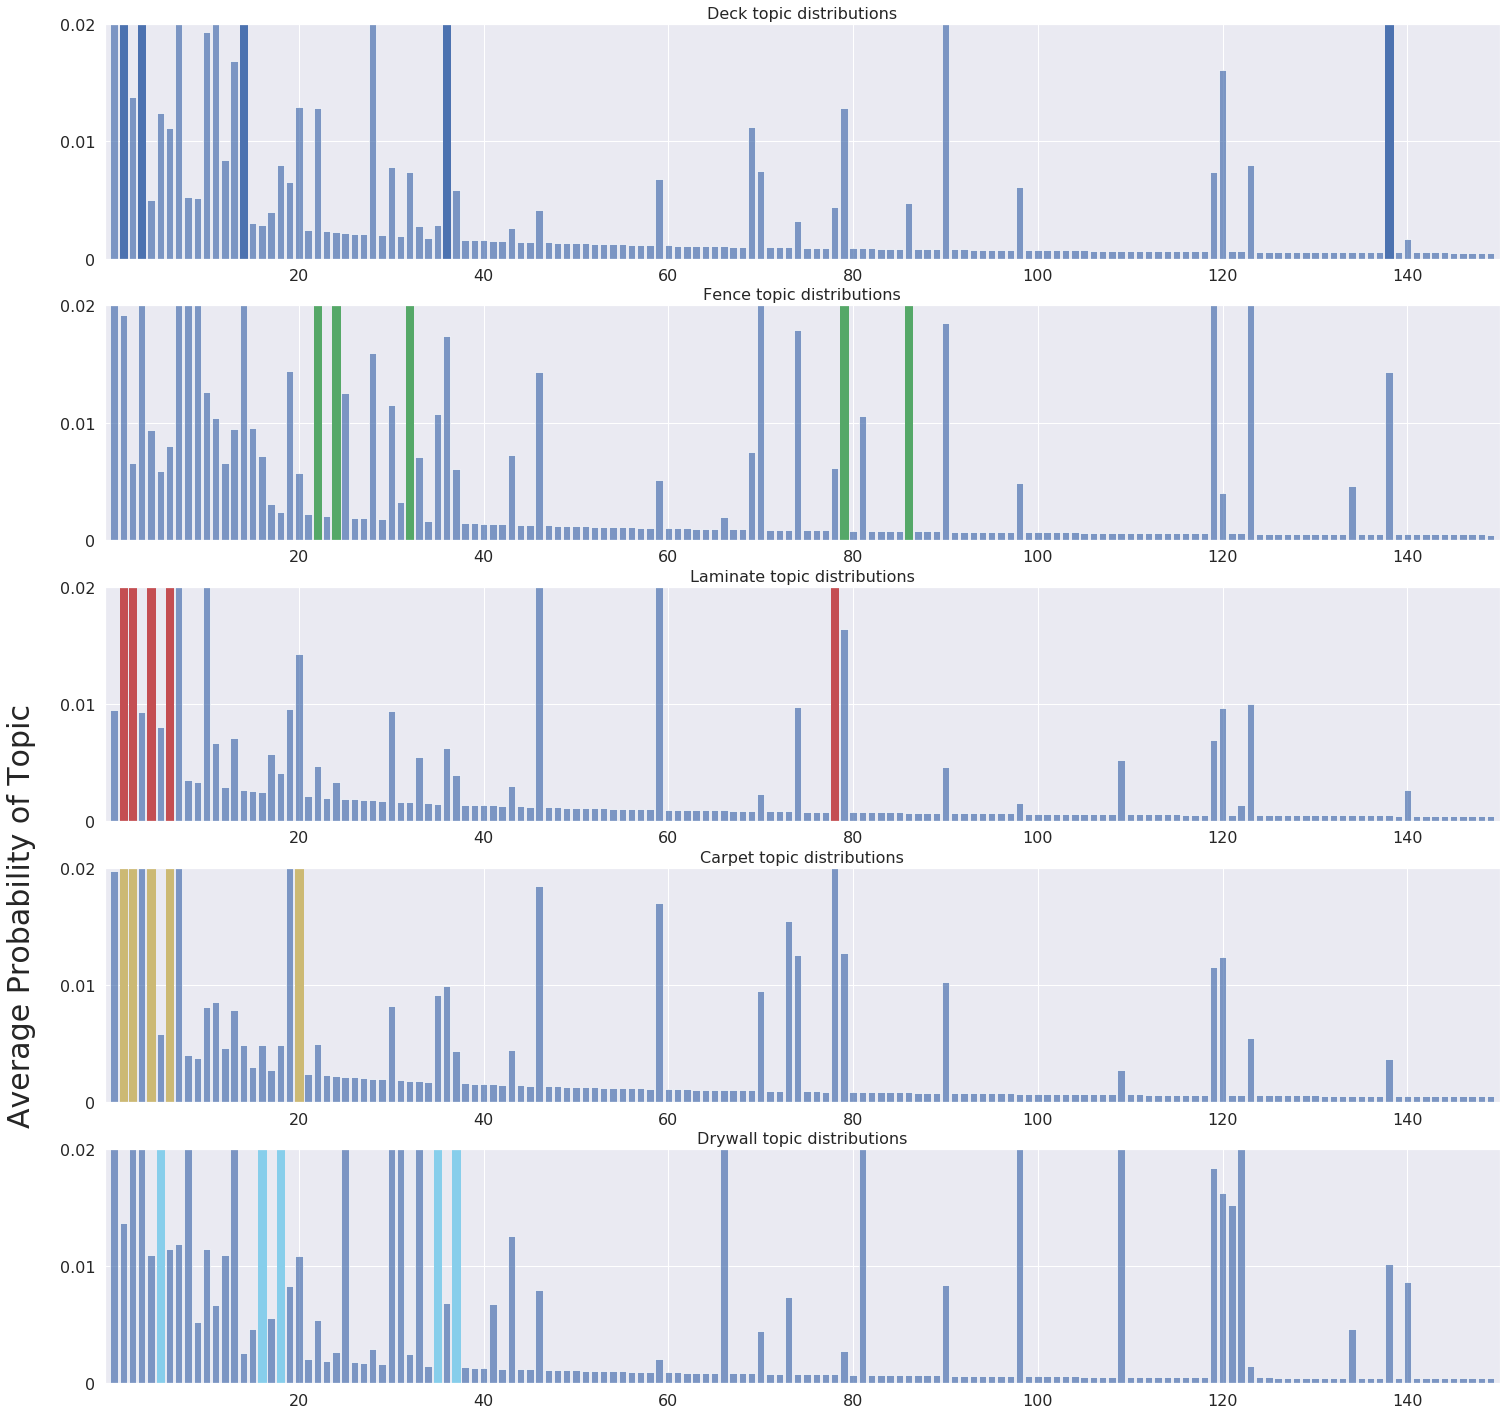

In [42]:
# visualize distribution plots for topics
fig, [ax1,ax2,ax3, ax4, ax5] = plt.subplots(5,1,figsize=(25,25))

nr_top_bars = 5

ax1.set_title("Deck topic distributions", fontsize=16)
ax2.set_title("Fence topic distributions", fontsize=16)
ax3.set_title("Laminate topic distributions", fontsize=16)
ax4.set_title("Carpet topic distributions", fontsize=16)
ax5.set_title("Drywall topic distributions", fontsize=16)
ax5.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5],
                                   [deck_topic_dist,
                                    fence_topic_dist,
                                    laminate_topic_dist,
                                    carpet_topic_dist,
                                    drywall_topic_dist],
                                   ['b','g','r','y','skyblue']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=1.)

#### Look at words the top topics contain

In [43]:
# function to gather the top topics for lda features
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [44]:
# output the top topics
for category, distribution in zip(['Deck', 'Fence', 'Laminate', 'Carpet', 'Drywall'], 
                                  [deck_topic_dist,
                                   fence_topic_dist,
                                   laminate_topic_dist,
                                   carpet_topic_dist,
                                   drywall_topic_dist]):
    print("Looking up top words from top topics from {}.".format(category))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from Deck.
For topic 1, the top words are: diy, stair, makeov, carpet, backyard.
For topic 3, the top words are: outdoor, home, kitchen, bar, build.
For topic 14, the top words are: build, deck, diy, modern, ep.
For topic 36, the top words are: idea, home, great, outdoor, patio.
For topic 138, the top words are: deck, use, diy, build, drywal.

Looking up top words from top topics from Fence.
For topic 22, the top words are: gate, 3, fenc, build, repair.
For topic 24, the top words are: fenc, post, panel, instal, wooden.
For topic 32, the top words are: post, fenc, repair, broken, joint.
For topic 79, the top words are: wood, fenc, stain, paint, heat.
For topic 86, the top words are: fenc, link, chain, picket, repair.

Looking up top words from top topics from Laminate.
For topic 1, the top words are: diy, stair, makeov, carpet, backyard.
For topic 2, the top words are: vinyl, step, floor, instal, plank.
For topic 4, the top words are: floor, lamin, 

#### Visualizations for LDA -- not needed for training model -- END
-----------------

## Word2Vec

### Train

In [45]:
# show number of sentences and texts for w2v
sentences = []
for sentence_group in training_df.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(training_df)))

Number of sentences: 761.
Number of texts: 701.


In [46]:
%%time
# set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 2    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 86 ms, sys: 41 µs, total: 86 ms
Wall time: 83.4 ms


In [47]:
# function to convert a list of lists of words 
# to a feature vector for Word2Vec
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # initialize a counter for number of words in a review
    nwords = 0
    # loop over each word in the comment and, if it is in the model's 
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

training_df['w2v_features'] = list(map(lambda sen_group: 
                                     get_w2v_features(W2Vmodel, sen_group),
                                     training_df.tokenized_sentences))

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [48]:
#training_df.head(3)

-----------------
#### Visualizations for Word2Vec -- not needed for training model -- START

In [49]:
# compute mean of word2vec features for training data
deck_w2v_dist = training_df.loc[training_df.primary_category == 
                                'build_deck', 'w2v_features'].mean()

fence_w2v_dist = training_df.loc[training_df.primary_category == 
                                 'repair_wood_fence', 'w2v_features'].mean()

laminate_w2v_dist = training_df.loc[training_df.primary_category == 
                                    'laminate_flooring', 'w2v_features'].mean()

carpet_w2v_dist = training_df.loc[training_df.primary_category == 
                                  'carpet_flooring', 'w2v_features'].mean()

drywall_w2v_dist = training_df.loc[training_df.primary_category == 
                                   'drywall_repair', 'w2v_features'].mean()

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


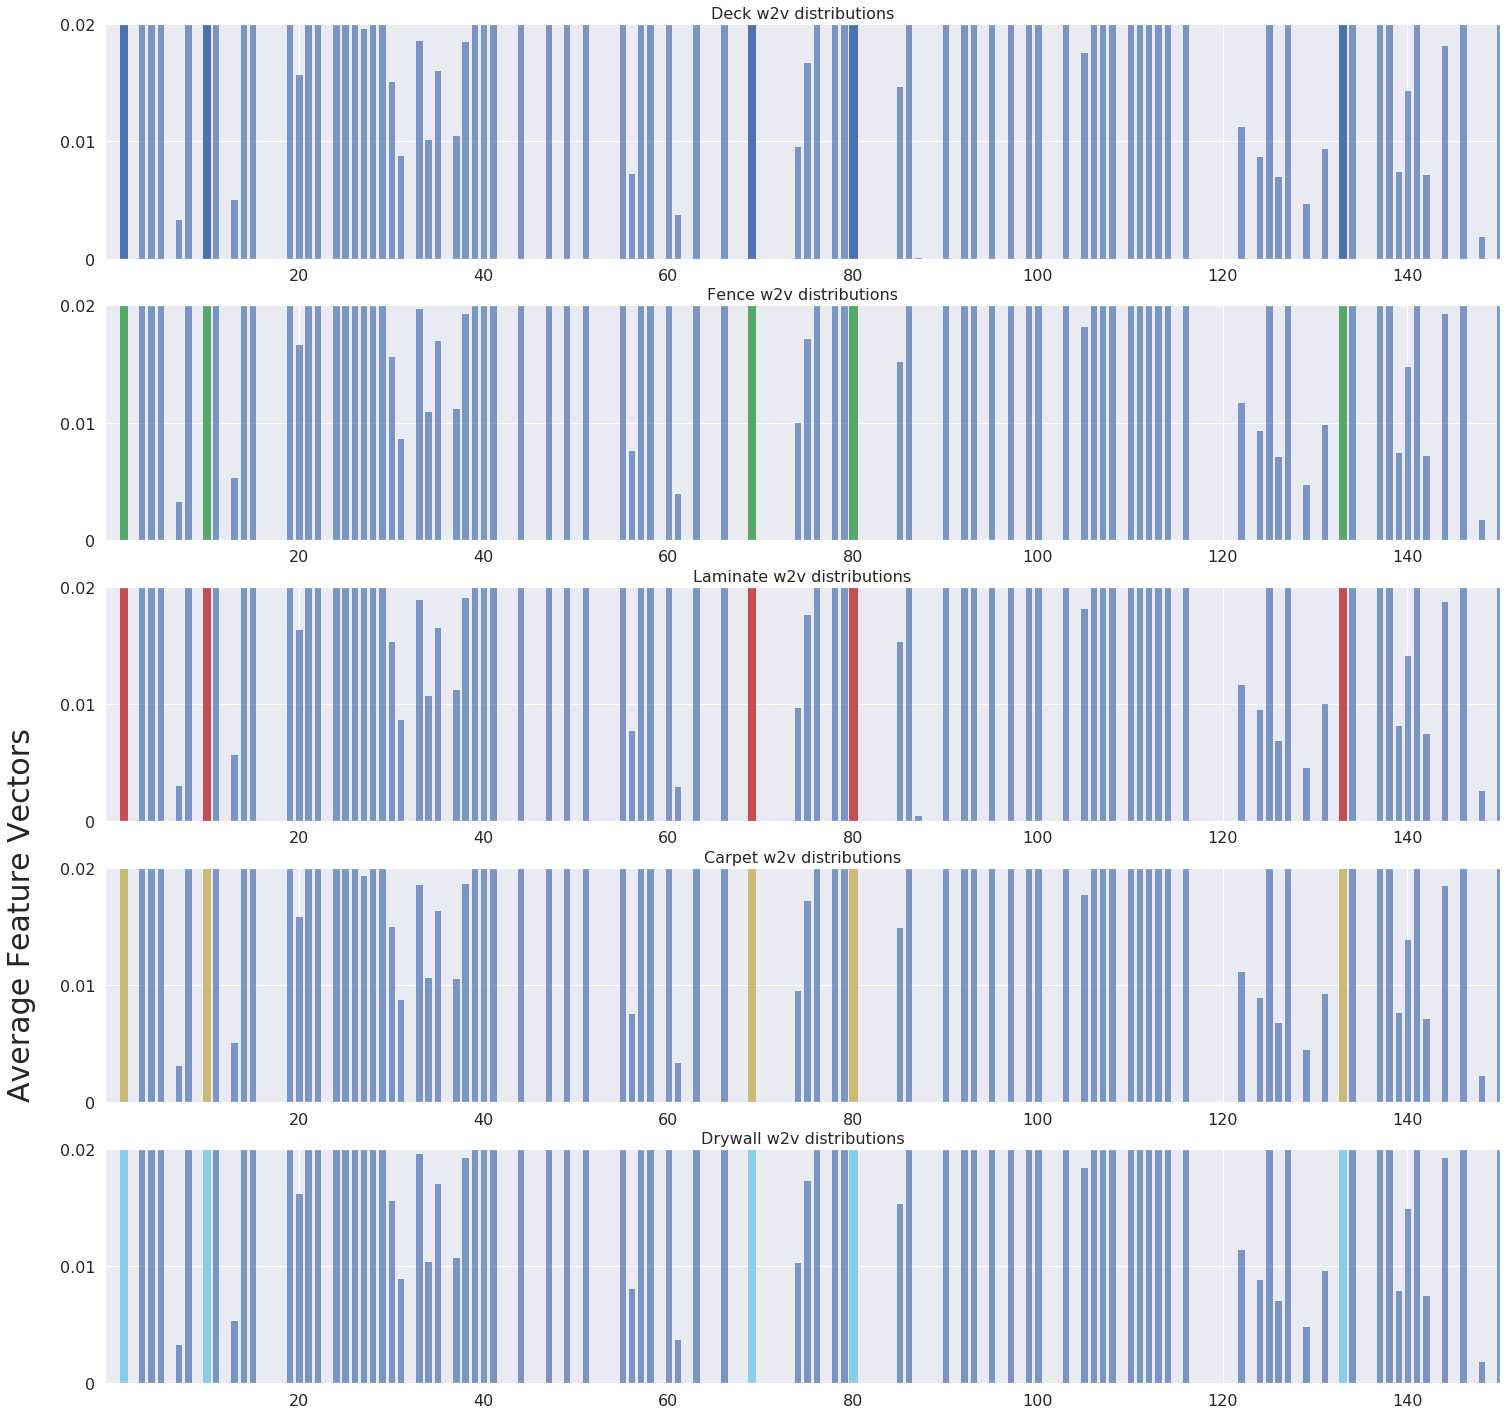

In [50]:
# visualize the distributions
fig, [ax1,ax2,ax3, ax4, ax5] = plt.subplots(5,1,figsize=(25,25))

nr_top_bars = 5

ax1.set_title("Deck w2v distributions", fontsize=16)
ax2.set_title("Fence w2v distributions", fontsize=16)
ax3.set_title("Laminate w2v distributions", fontsize=16)
ax4.set_title("Carpet w2v distributions", fontsize=16)
ax5.set_title("Drywall w2v distributions", fontsize=16)
ax5.text(-10, 0.04, "Average Feature Vectors", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5],
                                   [deck_w2v_dist,
                                    fence_w2v_dist,
                                    laminate_w2v_dist,
                                    carpet_w2v_dist,
                                    drywall_w2v_dist],
                                   ['b','g','r','y','skyblue']):
    # individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # general plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=1.)

#### Visualizations for Word2Vec -- not needed for training model -- END
-----------------

### Classification and Hyperparameter Tuning

In [51]:
# encode the labels from e.g., 'drywall_repair' --> 0
label_encoder = LabelEncoder()

label_encoder.fit(training_df.primary_category)
training_df['category_id'] = label_encoder.transform(training_df.primary_category)

In [52]:
#training_df.tail(3)

In [53]:
# create first pipeline for base without reducing features
pipe = Pipeline([('classifier' , RandomForestClassifier())])

# create param grid.
param_grid = [{'classifier' : [LogisticRegression()], 
               'classifier__penalty' : ['l1', 'l2'],
               'classifier__C' : np.logspace(-4, 4, 20)},
              {'classifier' : [RandomForestClassifier()],
               'classifier__n_estimators' : list(range(10,101,10)),
               'classifier__max_features' : list(range(6,32,5))}]

In [54]:
# function to perform exhaustive cross validation and 
# identify the best model based on 'log_loss'
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', 
                           cv=nr_folds, n_jobs=-1, verbose=True)
    
    best_model = grid_cv.fit(X, y)
    
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'rank_test_score']
    
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [55]:
# training_df['lda_features'] and training_df['w2v_features'] don't 
# have the needed shape and type yet, need to transform every entry
X_train_lda = np.array(list(map(np.array, training_df.lda_features)))
X_train_w2v = np.array(list(map(np.array, training_df.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [56]:
# store all models in a dictionary
models = dict()

## Logistic Regression -- because working with log loss which requires predict_proba( )

In [57]:
## commented out because the model does not perform well enough

# # get best lda model
# best_lda = get_cross_validated_model(pipe, param_grid, X_train_lda, training_df.category_id)

# #models['best_lr_lda'] = best_lr_lda
# models['best_lda'] = best_lda

In [58]:
## model with best classification performance

# get best w2v model
best_w2v = get_cross_validated_model(pipe, param_grid, X_train_w2v, training_df.category_id)

#models['best_lr_w2v'] = best_lr_w2v
models['best_w2v'] = best_w2v

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.2min finished
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warni

,mean_test_score,rank_test_score,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__max_features,param_classifier__n_estimators
32,-0.589491,1,"LogisticRegression(C=545.5594781168514, class_...",545.559,l1,NaN,NaN
34,-0.638922,2,"LogisticRegression(C=545.5594781168514, class_...",1438.45,l1,NaN,NaN
30,-0.642721,3,"LogisticRegression(C=545.5594781168514, class_...",206.914,l1,NaN,NaN
39,-0.706973,4,"LogisticRegression(C=545.5594781168514, class_...",10000,l2,NaN,NaN
36,-0.759461,5,"LogisticRegression(C=545.5594781168514, class_...",3792.69,l1,NaN,NaN


In [59]:
## commented out because the model does not perform well enough

# # get best lda and w2v models combined
# best_combined = get_cross_validated_model(pipe, param_grid, X_train_combined, training_df.category_id)

# #models['best_lr_combined'] = best_lr_combined
# models['best_combined'] = best_combined

In [60]:
# output each models best score
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_w2v has a test score of: -0.5895


## Save best models

In [130]:
# save the model to disk
#lda_file = 'models/best_lda_model.pkl'
w2v_file = 'models/best_w2v_model.pkl'
#combined_file = 'models/best_combined_model.sav'

In [131]:
#pickle.dump(models['best_lda'], open(lda_file, 'wb'))
pickle.dump(best_w2v, open(w2v_file, 'wb'))
#pickle.dump(models['best_combined'], open(combined_file, 'wb'))

----------------------
# Test Unseen Dataset and Validate Results

### Create new Dataframe of unseen data to Test model

In [63]:
# preprocess test data
lda_preprocessing(testing_df)
w2v_preprocessing(testing_df)

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [64]:
testing_df.head(1)

,video_id,title,subtitles,primary_category,text,txt_len,summary,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences
2,0COOF3BwgKI,fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools...","[fix, small, nail, holes, in, walls, fast, and...","[fix, small, nail, holes, walls, fast, make, d...","[fix, small, nail, hole, wall, fast, make, dis...","[fix, small, nail, hole, wall, fast, make, dis...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]",[fix small nail holes in walls fast and make t...,"[[fix, small, nail, holes, in, walls, fast, an..."


In [65]:
# testing_df['lda_features'] = list(map(lambda doc:
#                                      document_to_lda_features(LDAmodel, doc),
#                                      testing_df.bow.copy()))

testing_df['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     testing_df.tokenized_sentences.copy()))

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [66]:
testing_df.head(1)

,video_id,title,subtitles,primary_category,text,txt_len,summary,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences,w2v_features
2,0COOF3BwgKI,fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools...","[fix, small, nail, holes, in, walls, fast, and...","[fix, small, nail, holes, walls, fast, make, d...","[fix, small, nail, hole, wall, fast, make, dis...","[fix, small, nail, hole, wall, fast, make, dis...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]",[fix small nail holes in walls fast and make t...,"[[fix, small, nail, holes, in, walls, fast, an...","[-0.09746495, 0.16172683, -0.043777898, 0.1052..."


In [67]:
testing_df.reset_index(inplace=True, drop=True)

In [68]:
testing_df[['video_id','primary_category','w2v_features']].head()

,video_id,primary_category,w2v_features
0,0COOF3BwgKI,drywall_repair,"[-0.09746495, 0.16172683, -0.043777898, 0.1052..."
1,0UtTMhzCpZc,drywall_repair,"[-0.093365714, 0.15454245, -0.041482326, 0.100..."
2,0jhqbnM-5XQ,build_deck,"[-0.102106944, 0.16907229, -0.045594733, 0.109..."
3,1D4oA-dkwGc,drywall_repair,"[-0.103342, 0.17099173, -0.04561319, 0.1122839..."
4,1IJk16_KSfs,repair_wood_fence,"[-0.11609205, 0.1899097, -0.050498206, 0.12393..."


In [69]:
for feat in testing_df[testing_df.index == 256]['w2v_features']:
    #print(feat)
    continue

In [70]:
t_test = list(map(np.array, testing_df['w2v_features']))

In [71]:
np.array(t_test)

array([[-0.09746495,  0.16172683, -0.0437779 , ..., -0.06190474,
        -0.0883598 ,  0.11365314],
       [-0.09336571,  0.15454245, -0.04148233, ..., -0.05876836,
        -0.08473346,  0.10899695],
       [-0.10210694,  0.16907229, -0.04559473, ..., -0.06447183,
        -0.09235282,  0.11916456],
       ...,
       [-0.10783836,  0.17909724, -0.04886088, ..., -0.06926811,
        -0.09809145,  0.12600648],
       [-0.11194152,  0.1865675 , -0.05010909, ..., -0.07046714,
        -0.10094476,  0.12978655],
       [-0.12928973,  0.21578667, -0.05813219, ..., -0.08234505,
        -0.11778636,  0.15269205]], dtype=float32)

In [72]:
# training_df['lda_features'] and training_df['w2v_features'] don't 
# have the needed shape and type yet, need to transform every entry
#X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, testing_df.w2v_features)))
#X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

In [73]:
testing_df.w2v_features[0][0]

-0.09746495

In [128]:
X_test_w2v

array([[-0.09746495,  0.16172683, -0.0437779 , ..., -0.06190474,
        -0.0883598 ,  0.11365314],
       [-0.09336571,  0.15454245, -0.04148233, ..., -0.05876836,
        -0.08473346,  0.10899695],
       [-0.10210694,  0.16907229, -0.04559473, ..., -0.06447183,
        -0.09235282,  0.11916456],
       ...,
       [-0.10783836,  0.17909724, -0.04886088, ..., -0.06926811,
        -0.09809145,  0.12600648],
       [-0.11194152,  0.1865675 , -0.05010909, ..., -0.07046714,
        -0.10094476,  0.12978655],
       [-0.12928973,  0.21578667, -0.05813219, ..., -0.08234505,
        -0.11778636,  0.15269205]], dtype=float32)

In [75]:
testing_df['category_id'] = label_encoder.transform(testing_df.primary_category.copy())
#testing_df.head(3)

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
testing_df.head(1)

,video_id,title,subtitles,primary_category,text,txt_len,summary,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences,w2v_features,category_id
0,0COOF3BwgKI,fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools...","[fix, small, nail, holes, in, walls, fast, and...","[fix, small, nail, holes, walls, fast, make, d...","[fix, small, nail, hole, wall, fast, make, dis...","[fix, small, nail, hole, wall, fast, make, dis...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]",[fix small nail holes in walls fast and make t...,"[[fix, small, nail, holes, in, walls, fast, an...","[-0.09746495, 0.16172683, -0.043777898, 0.1052...",2


In [77]:
label_encoder.classes_

array(['build_deck', 'carpet_flooring', 'drywall_repair',
       'laminate_flooring', 'repair_wood_fence'], dtype=object)

In [78]:
#best_lda.predict_proba(X_test_lda)

In [79]:
predictions = best_w2v.predict_proba(X_test_w2v)

In [80]:
predictions

array([[1.23402149e-02, 1.13719655e-02, 8.52034690e-01, 1.01420612e-02,
        1.14111068e-01],
       [1.06173340e-02, 5.29113779e-02, 8.39732583e-01, 8.70243103e-02,
        9.71439453e-03],
       [2.12639392e-01, 2.52419594e-02, 2.88655053e-01, 2.91061829e-02,
        4.44357413e-01],
       ...,
       [6.38139047e-03, 5.70227458e-01, 3.48986061e-01, 3.31437374e-02,
        4.12613533e-02],
       [1.53399994e-02, 3.11856698e-01, 3.12803139e-02, 2.16096735e-02,
        6.19913315e-01],
       [6.82549478e-04, 6.24478618e-03, 1.48163200e-02, 9.70467876e-01,
        7.78846791e-03]])

In [81]:
idx = testing_df.index[testing_df['video_id'] == '0jhqbnM-5XQ'].tolist()

In [82]:
predictions[idx]

array([[0.21263939, 0.02524196, 0.28865505, 0.02910618, 0.44435741]])

In [ ]:
#best_combined.predict_proba(X_test_combined)

In [99]:
deck = testing_df[testing_df.primary_category=='build_deck'].copy()
laminate = testing_df[testing_df.primary_category=='laminate_flooring'].copy()
fence = testing_df[testing_df.primary_category=='repair_wood_fence'].copy()

In [100]:
import random
from datetime import datetime
sample_deck = deck.sample(n=1, replace=False, random_state=random.seed(datetime.now()))
sample_laminate = laminate.sample(n=1, replace=False, random_state=random.seed(datetime.now()))
sample_fence = fence.sample(n=1, replace=False, random_state=random.seed(datetime.now()))

In [101]:
new_df = pd.concat([sample_deck, sample_laminate, sample_fence], ignore_index=True)
new_df.reset_index(inplace=True, drop=True)

In [102]:
label_encoder = LabelEncoder()
label_encoder.fit(new_df.primary_category)

LabelEncoder()

In [103]:
label_encoder.classes_

array(['build_deck', 'laminate_flooring', 'repair_wood_fence'],
      dtype=object)

In [104]:
X_test_sample_w2v = np.array(list(map(np.array, new_df.w2v_features)))

In [105]:
new_df['category_id'] = label_encoder.transform(new_df.primary_category.copy())

In [106]:
new_df

,video_id,title,subtitles,primary_category,text,txt_len,summary,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences,w2v_features,category_id
0,u910hpUiDGA,basic deck building explained in less than thr...,this is a suggested video someone requested it...,build_deck,"Personally, I would put a row of staggered blo...",2723,"Fantastic, superb and brilliant., awesome, gla...","[basic, deck, building, explained, in, less, t...","[basic, deck, building, explained, less, three...","[basic, deck, building, explained, le, three, ...","[basic, deck, build, explain, le, three, minut]","[(48, 1), (49, 1), (118, 1)]",[basic deck building explained in less than th...,"[[basic, deck, building, explained, in, less, ...","[-0.10483445, 0.17372563, -0.047862668, 0.1117...",0
1,pA3NK5sH40k,installing 100% waterproof flooring with nucore,introducing the newest innovation in flooring ...,laminate_flooring,"Water is wet, Subscribe for no reason, Thanks!...",18549,Does it have uv protection????????????????????...,"[installing, 100, waterproof, flooring, with, ...","[installing, 100, waterproof, flooring, nucore]","[installing, 100, waterproof, flooring, nucore]","[instal, 100, waterproof, floor, nucor]","[(25, 1), (26, 1)]",[installing 100% waterproof flooring with nucore],"[[installing, 100, waterproof, flooring, with,...","[-0.10104628, 0.16907822, -0.04514201, 0.11001...",1
2,TUtu8nXLVsU,diy project - table saw extension and out feed...,hey everyone today I am building an extension ...,repair_wood_fence,"Hi,izzy this idea it's so good thks., izzy swa...",25425,@michael olsen thank you michael same to you a...,"[diy, project, table, saw, extension, and, out...","[diy, project, table, saw, extension, feed, ta...","[diy, project, table, saw, extension, feed, ta...","[diy, project, tabl, saw, extens, feed, tabl, ...","[(22, 1), (23, 1), (41, 1), (97, 2), (103, 1)]",[diy project - table saw extension and out fee...,"[[diy, project, table, saw, extension, and, ou...","[-0.098934755, 0.16394776, -0.045036014, 0.107...",2


In [111]:
predictions = best_w2v.predict_proba(X_test_sample_w2v)

In [112]:
predictions

array([[8.97746150e-01, 2.00977149e-02, 4.77766118e-03, 2.06409318e-04,
        7.71720650e-02],
       [1.22616439e-02, 1.05983772e-01, 4.13989747e-02, 8.39912362e-01,
        4.43247131e-04],
       [5.14974434e-01, 9.70741603e-02, 3.20480331e-02, 2.65023381e-02,
        3.29401035e-01]])

## Output Training and Testing Data

In [ ]:
#train_to_pkl_filename = 'data/csv_files/train_data.pkl'
#test_to_pkl_filename = 'data/csv_files/test_data.pkl'
#training_df.to_pickle(train_to_pkl_filename)
#testing_df.to_pickle(test_to_pkl_filename)

In [129]:
train_to_csv_filename = 'data/csv_files/train_data.csv'
test_to_csv_filename = 'data/csv_files/test_data.csv'
training_df.to_csv(train_to_csv_filename, sep=',', index=False)
testing_df.to_csv(test_to_csv_filename, sep=',', index=False)

In [132]:
df_sample = pd.read_pickle('data/csv_files/test_data.pkl')

In [138]:
df_sample.title

0      fix small nail holes in walls fast and make th...
1      large plaster repairs skim coating house painting
2            how to make a four season room from a porch
3      how to repair drywall damage after baseboards ...
4                  foam vs concrete - fence post setting
5      diy hawk and trowel techniques for skim coat p...
6                   how to install a floating wood floor
7      how to carpet van interior panels - diy van ca...
8      trafficmaster allure vinyl plank flooring inst...
9          how to patch drywall around an electrical box
10                   honda accord carpet removal install
11         diy jon boat interior boat carpet on a budget
12            fastest easiest way to remove a fence post
13     how to repair drywall ceiling water damaged dr...
14          how to install laminate flooring transitions
15     wood fence bracket comparison revolution fence...
16               how to attach a ledger board for a deck
17               how to build a